# Predicting Irish house energy ratings using supervised machine learning methods

## AIB Datahack

## What's this all about?

During my recent career break, where I returned to college to study for an M.Sc in Business Analytics at UCD Smurfit, myself and my good buddy @Padams02 decided to take on the AIB Datahack which was held in, I think, November 2016. The Datahack was hosted by AIB in their head office in Dublin 4, and consisted of a full days work (8 hours) tackling a machine learning problem. 

The challenge we were presented with that morning was a supervised learning problem. Armed with only our laptops, the following challange was presented to us: Could we find a method to accurately predict energy ratings for houses in Ireland based on a set of characteristics that the house had. We went into the competition confident that we knew what we were doing, but it quickly dawned on us that we still had a lot to learn. All in all, it proved to be a very worthwhile experience and focused us both on what we needed to learn over the coming months.

Now that I've completed my course and have returned to work, I'm going to try and tackle the problem again in my spare time, and see if I can do a little better this time around.

Having already run through the data, using [this](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) very useful Kernal I found on Kaggle , I'm going to properly step through what I've learned over a series of notebooks. The rough plan I have starting out for each notebook is as follows:

1. Initial analysis and exploration (This notebook)
2. Deeper exploration
3. Data cleaning and feature engineering
4. Machine learning

As I dive deeper into the Machine Learning aspect of this challenge I may produce more notebooks, but for now I'll keep it as just the one.

So without further adieu...lets get stuck in!

In [57]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [58]:
# Data Import
train = pd.read_csv("large_data/training.txt", sep='\t', encoding='ISO-8859-1', header=0, low_memory=False, index_col=0)
test = pd.read_csv("large_data/testing.txt", sep='\t', encoding='ISO-8859-1', header=0, low_memory=False, index_col=0)

train.head(3)

,County,Type,Year,RatingType,EnergyRatingCat,EnergyRatingCont,GroundFloorArea,AvgWallU,AvgRoofU,AvgFloorU,...,EffSecondHeatGenPlant,PercSecondHeat,FuelTypeThirdBoiler,EffThirdHeatGenPlant,PercThirdHeat,HeatingSystemSolarSpace,TotPrimaryEnergyFac,TotCO2Emissions,PrimaryEnergySecondarySpace,EnergyMainWater
BuildingID,,,,,,,,,,,,,,,,,,,,,
190835,Co. Wexford,Mid-terrace house,Y1890.0,Existing,F,418.42,52.04 sq. m,2.10,2.30,0.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,2335.6809
523113,Co. Clare,Detached house,Y1901.0,Existing,G,520.35,147.44 sq. m,2.01,0.75,0.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7144.838,4470.0759
271393,Co. Kerry,Detached house,Y1968.0,Existing,D2,281.33,104.84 sq. m,0.38,0.13,0.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2127.347,5837.4729


In [59]:
# Dataframe shapes
print("Train: ", train.shape)
print("Test: ", test.shape)

Train:  (464514, 140)
Test:  (159262, 140)


In [60]:
# Lets check the columns
train.columns

Index(['County', 'Type', 'Year', 'RatingType', 'EnergyRatingCat',
       'EnergyRatingCont', 'GroundFloorArea', 'AvgWallU', 'AvgRoofU',
       'AvgFloorU',
       ...
       'EffSecondHeatGenPlant', 'PercSecondHeat', 'FuelTypeThirdBoiler',
       'EffThirdHeatGenPlant', 'PercThirdHeat', 'HeatingSystemSolarSpace',
       'TotPrimaryEnergyFac', 'TotCO2Emissions', 'PrimaryEnergySecondarySpace',
       'EnergyMainWater'],
      dtype='object', length=140)

## Variable Exploration
In order to have some discipline in this analysis, I created an Excel spreadsheet (based on a suggestion in the kernal mentioned above) with the following columns:

* **Variable** - Variable name.
* **Type** - Identification of the variables' type. There are two possible values for this field: 'numerical' or 'categorical'. By 'numerical' we mean variables for which the values are numbers, and by 'categorical' we mean variables for which the values are categories.
* **Segment** - Identification of the variables' segment. We can define three possible segments: building, space or location. When we say 'building', we mean a variable that relates to the physical characteristics of the building (e.g. 'OverallQual'). When we say 'space', we mean a variable that reports space properties of the house (e.g. 'TotalBsmtSF'). Finally, when we say a 'location', we mean a variable that gives information about the place where the house is located (e.g. 'Neighborhood').
* **Expectation** - Our expectation about the variable influence in 'SalePrice'. We can use a categorical scale with 'High', 'Medium' and 'Low' as possible values.
* **Conclusion** - Our conclusions about the importance of the variable, after we give a quick look at the data. We can keep with the same categorical scale as in 'Expectation'.
* **Comments** - Any general comments that occured to us.

**Note:** This excel sheet is stored on my github account [here](https://github.com/mcsweena/AIB-Datahack-2016/blob/master/variable_analysis.xlsx) for anyone who wants to check it out.


This processes ended up being a very useful exercise, and made me properly think about each variable in the dataset. The variables I believe are most important, to begin with are as follows:
* Year
* AvgWallU, AvgRoofU, AvgFloorU, AvgWindowU, AvgDoorU
* ExposedWallArea, ExposedRoofArea
* TotFloorArea, TotWindowArea, TotDoorArea
* MainSHFuel, MainWHFuel, WallStructure

I'll begin with these and explore the other variables later.

## Data Exploration
With the above task complete, lets do the more interesting stuff....exploring the data!

We have two columns in our target variable dataframe: EnergyRatingCat and EnergyRatingCont. 

1. **EnergyRatingCat** is the categorical energy rating given to the property (A, B1, C2, etc.)
2. **EnergyRatingCont** on the otherhand is an numerical rating given to the property.

### EnergyRatingCat

In [61]:
# EnergyRatingCat
train.loc[:, 'EnergyRatingCat'].describe()

count     464502
unique        15
top           D1
freq       61134
Name: EnergyRatingCat, dtype: object

In [62]:
# Is there any null values in this column?
train.loc[:, 'EnergyRatingCat'].isnull().sum()

12

In [63]:
train[train.loc[:, 'EnergyRatingCat'].isnull()]

,County,Type,Year,RatingType,EnergyRatingCat,EnergyRatingCont,GroundFloorArea,AvgWallU,AvgRoofU,AvgFloorU,...,EffSecondHeatGenPlant,PercSecondHeat,FuelTypeThirdBoiler,EffThirdHeatGenPlant,PercThirdHeat,HeatingSystemSolarSpace,TotPrimaryEnergyFac,TotCO2Emissions,PrimaryEnergySecondarySpace,EnergyMainWater
BuildingID,,,,,,,,,,,,,,,,,,,,,
66956,NaN,NaN,Ynan,NaN,NaN,NaN,nan sq. m,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
413423,NaN,NaN,Ynan,NaN,NaN,NaN,nan sq. m,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92328,NaN,NaN,Ynan,NaN,NaN,NaN,nan sq. m,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68216,NaN,NaN,Ynan,NaN,NaN,NaN,nan sq. m,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415824,NaN,NaN,Ynan,NaN,NaN,NaN,nan sq. m,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
416368,NaN,NaN,Ynan,NaN,NaN,NaN,nan sq. m,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90347,NaN,NaN,Ynan,NaN,NaN,NaN,nan sq. m,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417267,NaN,NaN,Ynan,NaN,NaN,NaN,nan sq. m,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68842,NaN,NaN,Ynan,NaN,NaN,NaN,nan sq. m,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Quickly looking at these 12, there's no information at all in them, so lets drop them.

In [64]:
# before
len(train)

464514

In [65]:
train = train[pd.notnull(train['EnergyRatingCat'])]

In [66]:
# after
len(train)

464502

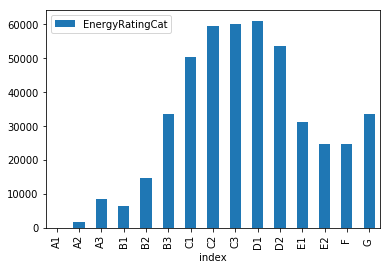

In [87]:
train.loc[:, 'EnergyRatingCat'].value_counts().reset_index().sort_values(by='index').set_index('index').plot(kind='bar');

As we can clearly see, the target variable is pretty unbalanced. There are tonnes of homes with 'C' and 'D' ratings but there are far fewer homes with 'A' and 'B' ratings. This is good to know because we will need to take this into account when implementing our ML algorithms.

### EnergyRatingCont

In [88]:
# EnergyRatingCont
train.loc[:, 'EnergyRatingCont'].describe()

count    464502.000000
mean        260.502160
std         208.511406
min         -63.960000
25%         175.280000
50%         224.290000
75%         299.120000
max       56423.710000
Name: EnergyRatingCont, dtype: float64

The first thing that jumps out to me here is there the minimum value is a negative number. Lets isolate only the negative numbers.

In [92]:
train[train.loc[:, 'EnergyRatingCont']<0]

,County,Type,Year,RatingType,EnergyRatingCat,EnergyRatingCont,GroundFloorArea,AvgWallU,AvgRoofU,AvgFloorU,...,EffSecondHeatGenPlant,PercSecondHeat,FuelTypeThirdBoiler,EffThirdHeatGenPlant,PercThirdHeat,HeatingSystemSolarSpace,TotPrimaryEnergyFac,TotCO2Emissions,PrimaryEnergySecondarySpace,EnergyMainWater
BuildingID,,,,,,,,,,,,,,,,,,,,,
77964,Co. Westmeath,Detached house,Y2009.0,Final,A1,-24.92,272.95 sq. m,0.10,0.10,0.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4526.483,1.123782e+03
646313,Co. Wexford,Semi-detached house,Y2016.0,Final,A1,-2.90,nan sq. m,0.17,0.07,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9224351.520,8.711080e+06
648684,Co. Wexford,Semi-detached house,Y2016.0,Final,A1,-2.93,nan sq. m,0.17,0.07,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9224352.606,8.711080e+06
442916,Co. Roscommon,Detached house,Y2013.0,Final,A1,-63.96,153.97 sq. m,0.10,0.10,0.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.089465e+03
625324,Co. Monaghan,Detached house,Y2015.0,Final,A1,-1.11,273.39 sq. m,0.13,0.16,0.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3219.907,2.481254e+03
431366,Co. Clare,Detached house,Y1940.0,Existing,A1,-2.03,286.0 sq. m,0.48,0.35,0.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1407.340,2.150447e+03


Ok, there's only 6 of them, and they're all rated A1, where is at the correct end of the scale of where we'd expect low numbers like these to be at. Maybe its possible for the rating algorithm to return a negative number if the houses are that energy efficient. Lets keep these in the data set for now.

In [93]:
# Is there any null values in this column? - Nope, all good.
train.loc[:, 'EnergyRatingCont'].isnull().sum()

0

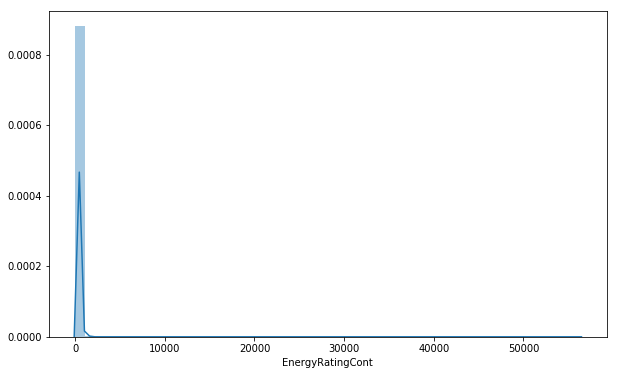

In [107]:
# Lets plot the data and have a look
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.distplot(train['EnergyRatingCont']);

Hmmm....looks like data is largely clustered close to zero, with a large tail extending to the right. Lets zoom in to values above 1000.

In [101]:
outliers = train[train.loc[:, 'EnergyRatingCont']>1000]
outliers.shape

(2345, 140)

In [102]:
outliers.head(5)

,County,Type,Year,RatingType,EnergyRatingCat,EnergyRatingCont,GroundFloorArea,AvgWallU,AvgRoofU,AvgFloorU,...,EffSecondHeatGenPlant,PercSecondHeat,FuelTypeThirdBoiler,EffThirdHeatGenPlant,PercThirdHeat,HeatingSystemSolarSpace,TotPrimaryEnergyFac,TotCO2Emissions,PrimaryEnergySecondarySpace,EnergyMainWater
BuildingID,,,,,,,,,,,,,,,,,,,,,
212192,Co. Galway,House,Y1900.0,Existing,G,1459.77,27.0 sq. m,2.10,0.13,1.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2615.628,1417.8924
644207,Limerick City,Ground-floor apartment,Y1900.0,Existing,G,1284.08,nan sq. m,2.05,2.30,0.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,2499.1200
283437,Dublin 1,Ground-floor apartment,Y1900.0,Existing,G,1525.85,32.0 sq. m,2.06,2.30,1.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,887.9526
133323,Co. Wicklow,Semi-detached house,Y1840.0,Existing,G,1079.74,55.8 sq. m,2.10,1.69,0.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7252.520,1188.7488
513850,Co. Cork,Ground-floor apartment,Y1950.0,Existing,G,1200.34,22.65 sq. m,NaN,2.30,1.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4868.100,765.0918


We can clearly see that the higher on the scale you go, the worse the energy rating your house will get. Out of curiosity, lets look at the distribution without houses rated above 1000.

In [104]:
train_1000 = train[train.EnergyRatingCont < 1000]
train_1000.head()

,County,Type,Year,RatingType,EnergyRatingCat,EnergyRatingCont,GroundFloorArea,AvgWallU,AvgRoofU,AvgFloorU,...,EffSecondHeatGenPlant,PercSecondHeat,FuelTypeThirdBoiler,EffThirdHeatGenPlant,PercThirdHeat,HeatingSystemSolarSpace,TotPrimaryEnergyFac,TotCO2Emissions,PrimaryEnergySecondarySpace,EnergyMainWater
BuildingID,,,,,,,,,,,,,,,,,,,,,
190835,Co. Wexford,Mid-terrace house,Y1890.0,Existing,F,418.42,52.04 sq. m,2.10,2.30,0.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,2335.6809
523113,Co. Clare,Detached house,Y1901.0,Existing,G,520.35,147.44 sq. m,2.01,0.75,0.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7144.838,4470.0759
271393,Co. Kerry,Detached house,Y1968.0,Existing,D2,281.33,104.84 sq. m,0.38,0.13,0.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2127.347,5837.4729
585961,Co. Cork,Semi-detached house,Y2002.0,Existing,C2,188.17,95.31 sq. m,0.55,0.26,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2771.886,3769.6248
624083,Co. Laois,Detached house,Y2002.0,Existing,B3,134.95,283.87 sq. m,0.55,0.26,0.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,5296.5828


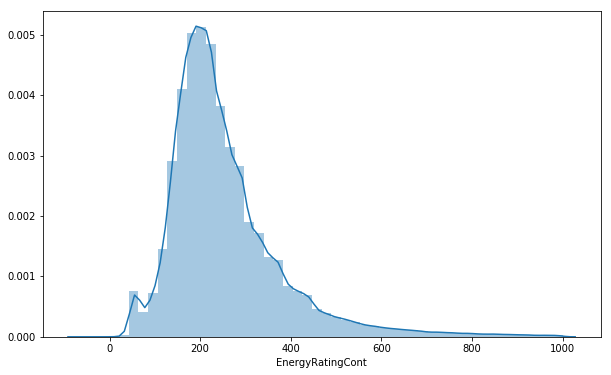

In [106]:
# Plotting
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.distplot(train_1000['EnergyRatingCont']);

Some quick observations on this plot:
1. The plot deviates from the normal distribution.
2. It has appreciable positive skewness.
3. Shows peakedness.

In [108]:
#skewness and kurtosis
print("Skewness: %f" % train['EnergyRatingCont'].skew())
print("Kurtosis: %f" % train['EnergyRatingCont'].kurt())

Skewness: 90.929173
Kurtosis: 18601.644571


In [109]:
#skewness and kurtosis
print("Skewness: %f" % train_1000['EnergyRatingCont'].skew())
print("Kurtosis: %f" % train_1000['EnergyRatingCont'].kurt())

Skewness: 1.888031
Kurtosis: 5.466775


**Conclustions**

If we are to look at this problem from a regression point of view, the large skew and kurtosis of the distribution (largely due to the incredibly high energy rating values given to some poorly insulated houses) will force us to return to this distribution and perform some transformations before attempting any machine learning problems. That's all I'll say for now but I will indeed revisit this when the really fun stuff begins.

## Exploring the numerical independant variables

In [110]:
# Lets isolate the important* columns
important_numerical_cols = ['Year', 'GroundFloorArea', 'AvgWallU', 'AvgRoofU', 'AvgFloorU', 
                  'AvgWindowU', 'AvgDoorU', 'ExposedWallArea', 'ExposedRoofArea', 
                  'TotFloorArea', 'TotWindowArea', 'TotDoorArea', 'EnergyRatingCont']

important_categorical_cols = ['MainSHFuel', 'MainWHFuel', 'WallStructure', 'EnergyRatingCat', 'EnergyRatingCont']

training_num = train.loc[:,important_numerical_cols]
training_cat = train.loc[:,important_categorical_cols]
training_cat.head(3)

# *What I have considered important from my initial Excel exerciese

,MainSHFuel,MainWHFuel,WallStructure,EnergyRatingCat,EnergyRatingCont
BuildingID,,,,,
190835,Heating Oil,Heating Oil,Masonry,F,418.42
523113,Heating Oil,Heating Oil,Masonry,G,520.35
271393,Heating Oil,Heating Oil,Masonry,D2,281.33


So that all these variables can be properly explored, a little but of processing has to be done to ensure they are all numerical only.

In [111]:
training_num.loc[:, 'Year'].isnull().sum()

0

In [156]:
# First, lets remove the 'Y' from infront of every year and the 'sq. m' from the end of GroundFloorArea 
# and assign them to a new variable
training_num['pYear'] = training_num['Year'].map(lambda x: int(float(x[1:])))
training_num['pGroundFloorArea'] = training_num['GroundFloorArea'].map(lambda x: float(x[:-5]))

In [157]:
training_num.head(3)

,Year,GroundFloorArea,AvgWallU,AvgRoofU,AvgFloorU,AvgWindowU,AvgDoorU,ExposedWallArea,ExposedRoofArea,TotFloorArea,TotWindowArea,TotDoorArea,EnergyRatingCont,pYear,pGroundFloorArea
BuildingID,,,,,,,,,,,,,,,
190835,Y1890.0,52.04 sq. m,2.10,2.30,0.61,2.71,3.00,32.78,73.08,33.69,7.08,2.05,418.42,1890,52.04
523113,Y1901.0,147.44 sq. m,2.01,0.75,0.94,2.63,3.96,211.22,93.40,96.77,37.00,5.95,520.35,1901,147.44
271393,Y1968.0,104.84 sq. m,0.38,0.13,0.68,2.81,0.00,94.41,104.84,104.84,17.90,0.00,281.33,1968,104.84


In [114]:
training_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464502 entries, 190835 to 429515
Data columns (total 15 columns):
Year                464502 non-null object
GroundFloorArea     464502 non-null object
AvgWallU            418057 non-null float64
AvgRoofU            464502 non-null float64
AvgFloorU           464502 non-null float64
AvgWindowU          464502 non-null float64
AvgDoorU            464502 non-null float64
ExposedWallArea     464502 non-null float64
ExposedRoofArea     464502 non-null float64
TotFloorArea        464502 non-null float64
TotWindowArea       464502 non-null float64
TotDoorArea         464502 non-null float64
EnergyRatingCont    464502 non-null float64
pYear               464502 non-null object
pGroundFloorArea    418342 non-null float64
dtypes: float64(12), object(3)
memory usage: 76.7+ MB


**Quick observation**

Straight away I can see the number of values for GroundFloorArea has reduced from 464514 to 418342 and I'm not sure why. Lets quickly look at these null values to see whats happened.

In [115]:
training_num[training_num['pGroundFloorArea'].isnull()].head()

,Year,GroundFloorArea,AvgWallU,AvgRoofU,AvgFloorU,AvgWindowU,AvgDoorU,ExposedWallArea,ExposedRoofArea,TotFloorArea,TotWindowArea,TotDoorArea,EnergyRatingCont,pYear,pGroundFloorArea
BuildingID,,,,,,,,,,,,,,,
659767,Y1954.0,nan sq. m,1.25,0.37,0.70,4.63,3.0,126.57,77.99,58.63,15.51,1.85,283.37,1954.0,NaN
361024,Y1998.0,nan sq. m,0.21,0.23,0.41,1.51,3.0,200.41,154.70,130.00,40.45,3.70,111.43,1998.0,NaN
191876,Y1932.0,nan sq. m,0.88,0.54,0.73,3.07,0.0,127.69,64.94,65.04,16.34,0.00,215.73,1932.0,NaN
471221,Y1980.0,nan sq. m,NaN,0.13,0.57,2.70,0.0,66.52,40.02,40.02,14.67,0.00,185.12,1980.0,NaN
146053,Y2002.0,nan sq. m,0.30,0.13,0.41,2.70,3.0,85.20,47.57,47.57,13.52,2.62,214.19,2002.0,NaN


Ah ok, we can see that the original GroundFloorArea variable had 'nan' values in but we still being counted as they were strings. Glad we found this!

### Scatter Plots - Numerical Variables

The next task is to plot some of these independent variables with the dependent variable and see if we can spot some trends/relationships that may be useful to us.

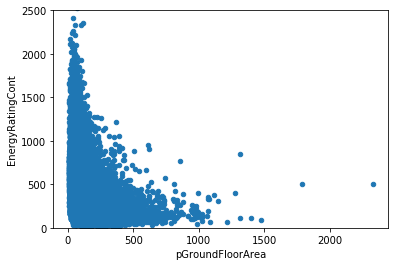

In [118]:
var = 'pGroundFloorArea'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

Straight away we can see a trend that areas with larger ground floor areas generally have better energy ratings.

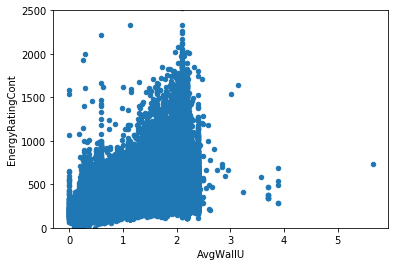

In [119]:
var = 'AvgWallU'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

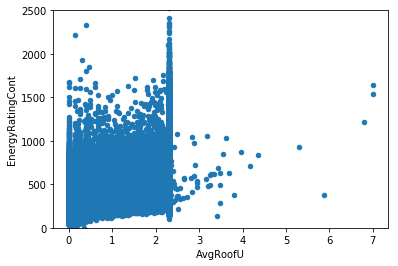

In [120]:
var = 'AvgRoofU'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

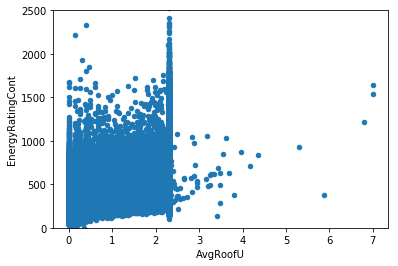

In [121]:
var = 'AvgRoofU'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

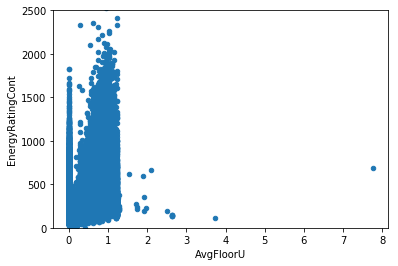

In [122]:
var = 'AvgFloorU'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

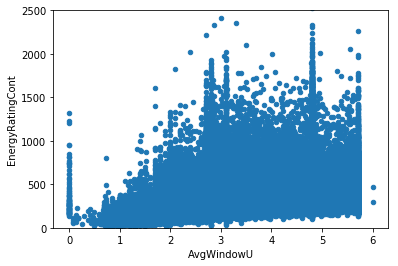

In [123]:
var = 'AvgWindowU'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

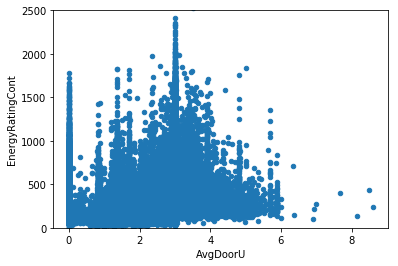

In [124]:
var = 'AvgDoorU'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

For all U values, there seems to be a weak positive linear relationship with the dependent variable.

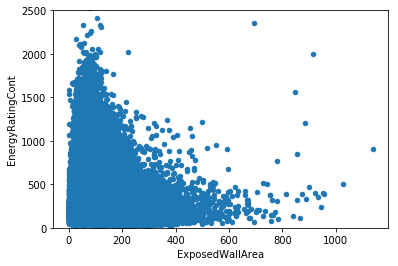

In [126]:
var = 'ExposedWallArea'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

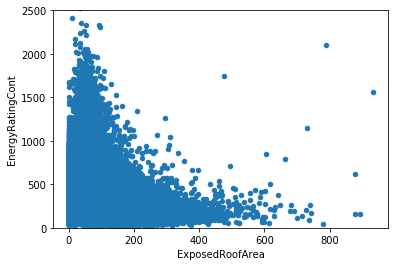

In [127]:
var = 'ExposedRoofArea'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

Similar to GroundFloorArea above, there looks like theres a trend where the higher the Exposed Roof or Wall area, the better energy rating the house has.

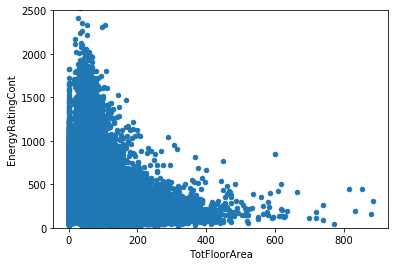

In [128]:
var = 'TotFloorArea'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

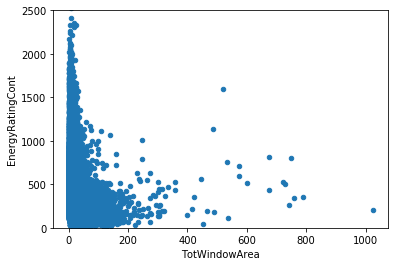

In [129]:
var = 'TotWindowArea'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

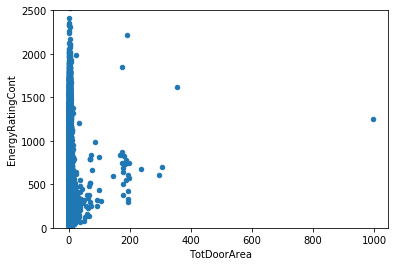

In [130]:
var = 'TotDoorArea'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

**Take aways**

One thing I've noticed from the plots above, is a lot of the independent variables have a lot of 0 values. Now when we talk about Total Areas and U values, 0 is not a valid answer. It's virtually impossible to have zero heat transfer through a wall and it's definitely impossible for a property to have no doors. Lets take a quick look at the volume of zero values each variable has.

In [135]:
zero_count = training_num.astype(bool).sum(axis=0).reset_index()
zero_count.columns = ['variable', 'sum']
zero_count['sum'] = zero_count['sum'].apply(lambda x: (x-len(training_num))*-1)
zero_count['percentage'] = zero_count['sum'].apply(lambda x: (x/len(training_num))*100)
zero_count

,variable,sum,percentage
0,Year,0,0.000000
1,GroundFloorArea,0,0.000000
2,AvgWallU,111,0.023897
3,AvgRoofU,48666,10.477027
4,AvgFloorU,53304,11.475516
5,AvgWindowU,85,0.018299
6,AvgDoorU,51386,11.062600
7,ExposedWallArea,118,0.025404
8,ExposedRoofArea,48666,10.477027
9,TotFloorArea,53300,11.474655


As we can see from the above summary, AvgRoofU, AvgFloorU, AvgDoorU, ExposedRoofArea, TotFloorArea and TotDoorArea all are showing over 10% of their values as zero, which doesn't make much sense. To this effect, we should treat them as null values and replace them, possibly with the variable mean, before using it in our model.

### Box Plots - Numerical Variables

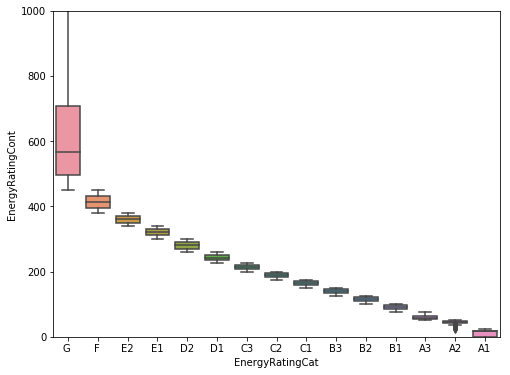

In [138]:
# Define the correct ordering of values
correct_sort = ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'E1', 'E2', 'F ', 'G ']

# plot
var = 'EnergyRatingCat'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=training_cat, order=correct_sort[::-1])
fig.axis(ymin=0, ymax=1000);

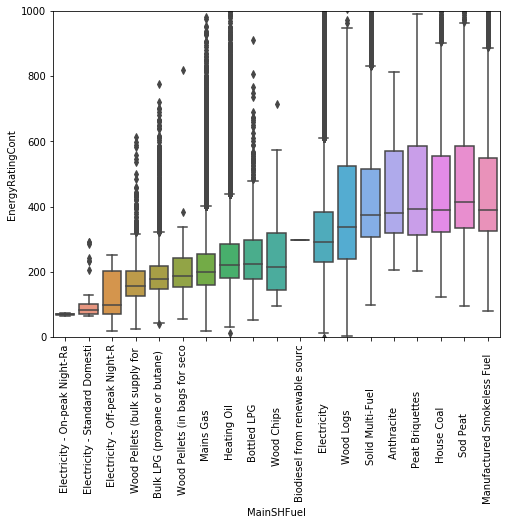

In [139]:
# Define the correct ordering of values - Ordering based on mean energy rating value (smallest to largest)
correct_sort = training_cat.groupby(['MainSHFuel']).mean().to_dict()['EnergyRatingCont']
correct_sort = sorted(correct_sort, key=correct_sort.get)

# plot
var = 'MainSHFuel'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=training_cat, order=correct_sort)
fig.set_xticklabels(ax.get_xticklabels(),rotation=90)
fig.axis(ymin=0, ymax=1000);

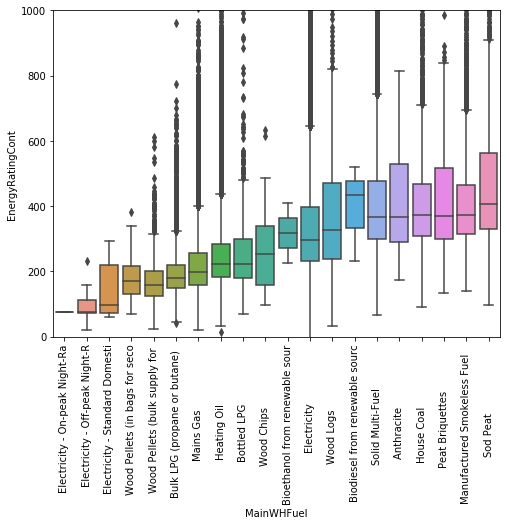

In [140]:
# Define the correct ordering of values - Ordering based on mean energy rating value (smallest to largest)
correct_sort = training_cat.groupby(['MainWHFuel']).mean().to_dict()['EnergyRatingCont']
correct_sort = sorted(correct_sort, key=correct_sort.get)

# plot
var = 'MainWHFuel'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=training_cat, order=correct_sort)
fig.set_xticklabels(ax.get_xticklabels(),rotation=90)
fig.axis(ymin=0, ymax=1000);

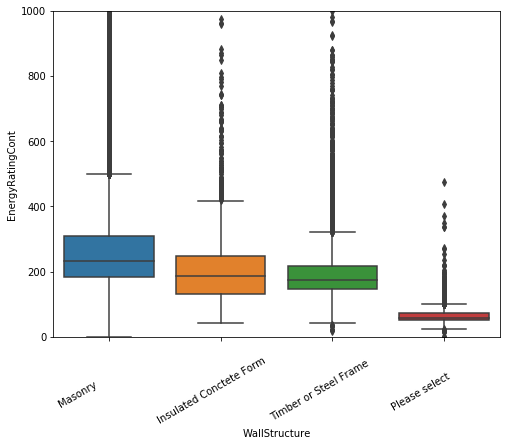

In [141]:
# plot
var = 'WallStructure'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=training_cat)
fig.set_xticklabels(ax.get_xticklabels(),rotation=30)
fig.axis(ymin=0, ymax=1000);

**Observation**

This plot proves very useful as we see an x value of 'Please select', which is clearly an error. Lets look at how many of these values are in the data set.

In [143]:
wall_str_errors = training_cat['WallStructure'].value_counts().reset_index()
wall_str_errors['percentage'] = wall_str_errors['WallStructure'].apply(lambda x: (x/len(training_cat))*100)
wall_str_errors

,index,WallStructure,percentage
0,Masonry,423828,91.243525
1,Timber or Steel Frame,29254,6.297928
2,Please select,6150,1.323999
3,Insulated Conctete Form,5270,1.134548


Ok so a very small percentage of these values are tagged as 'Please select'; roughly 1.36%. These will be replaced with an approprite value prior to model creation.

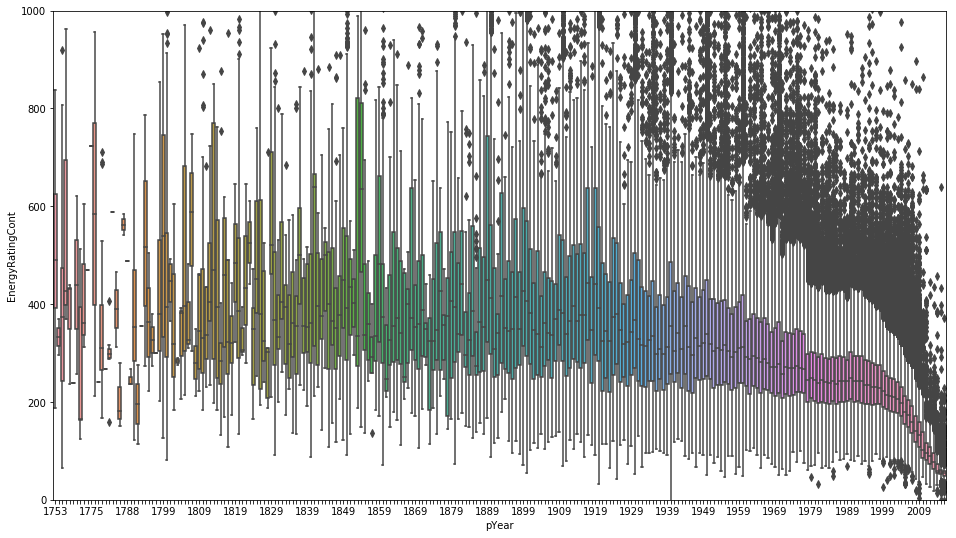

In [161]:
# plot
var = 'pYear'
f, ax = plt.subplots(figsize=(16, 9))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=training_num)
fig.set_xticklabels(ax.get_xticklabels(),rotation=0)
fig.axis(ymin=0, ymax=1000)

# Only show every 10th label on the x-axis
n = 10
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False);

A quick note on this graph. As expected, there seems to be a trend that as a home becomes newer, the better the property value becomes. The newer the house is also generally means the lower the variance.

## Conclusion

This has been a very useful excercise to familiarise myself with the data set. Every variable was considered and assigned a likelyhood as to how important it may be, based off my gut feeling. Some interesting trends and relationships presented themselves when exploring these variables and they definitely look like they will be useful. These chosen variables however are only a small subset of the overall amount available and while I believe they may not be as useful or informative, I may have gotten that completely wrong. So in the next notebook, I hope to do a deeper exploration of all these variables and end up with a solid list of variables that can be brought forward to my machine learning models.

**If anyone reads this and has any comments or suggestions on how I could improve what I've done above, please reach out to me!**

**Part 2: Coming soon!**